In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
from collections import Counter
pd.set_option('display.max_columns', 500)

In [2]:
songs = pd.read_csv('data/songs.csv', dtype={'idSong': 'float32', 'song': 'category'})

In [3]:
columns = {'distinct_id': 'category', 
           'idUser': 'float32', 
           'idSong': 'float32', 
           'Premium': 'category',
           'date': 'category'}

In [4]:
df = pd.read_csv('data/filtered_data.csv', dtype=columns)

In [5]:
print(df.shape)
df.head()

(898166, 5)


,Premium,distinct_id,idSong,idUser,date
0,True,1517adc8afe34-06674c418-b2033-e1000-1517adc8b003d,1455.0,254717.0,2016-01
1,True,151b5acaa3436-06170ce3f-569285f-e1000-151b5aca...,1267.0,260524.0,2016-01
2,True,151fb51704b174-028cc3d3e-770d5f50-e1000-151fb5...,1081.0,298505.0,2016-01
3,False,15188afdc1770-04dfc764a-77d525d-e1000-15188afd...,720.0,239346.0,2016-01
4,True,151a61e06202-0b1a334c8-6745156-e1000-151a61e06...,277.0,298592.0,2016-01


In [6]:
print(songs.shape)
songs.head()

(7301, 2)


,idSong,song
0,1455.0,Este Terco Corazon
1,5606.0,El Taxi
2,529.0,Llama por favor
3,5535.0,Tu respiracion
4,1267.0,No podras


In [7]:
triplets = df.groupby(['idUser', 'idSong'], as_index=False).agg({'date': 'count'}) \
                                        .sort_values('date', ascending=False)
triplets['count'] = triplets['date']
triplets = triplets.drop('date', axis=1)

In [8]:
triplets.head()

,idUser,idSong,count
121287,357518.0,5618.0,211
518167,795638.0,2855.0,72
15967,131705.0,418.0,62
262121,517484.0,644.0,59
575756,843548.0,961.0,54


In [9]:
triplets.shape

(708110, 3)

In [25]:
triplets.to_csv('data/filtered_data_triplets.csv', index=False)

In [10]:
triplets[triplets['count']>10].shape

(703, 3)

## Clip high count values [1..5]

- 1: [1]
- 2: [2,3]
- 3: [4,5,6]
- 4: [6..]

In [15]:
def rating(count):
    if count == 1: return 1
    elif count <= 3: return 2
    elif count <= 6: return 3
    else: return 4

In [17]:
triplets['rating'] = triplets['count'].apply(rating)

1    592928
2    100091
3     12287
4      2804
Name: rating, dtype: int64


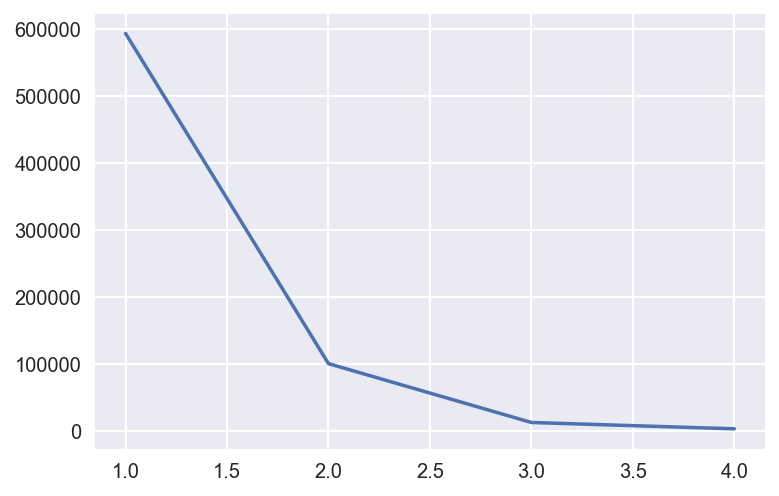

In [22]:
print(triplets['rating'].value_counts())
triplets['rating'].value_counts().plot()

In [18]:
triplets.head()

,idUser,idSong,count,rating
121287,357518.0,5618.0,211,4
518167,795638.0,2855.0,72,4
15967,131705.0,418.0,62,4
262121,517484.0,644.0,59,4
575756,843548.0,961.0,54,4


# Correlation matrix

In [25]:
userRatings = triplets.pivot_table(index=['idUser'], columns=['idSong'], values='rating')

In [26]:
userRatings.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Float64Index: 33945 entries, 8.0 to 1063228.0
Columns: 6917 entries, 1.0 to 14996.0
dtypes: float64(6917)
memory usage: 1.7 GB


In [28]:
# 22 min
corrMatrix = userRatings.corr(method='pearson', min_periods=100)

In [29]:
corrMatrix.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Float64Index: 6917 entries, 1.0 to 14996.0
Columns: 6917 entries, 1.0 to 14996.0
dtypes: float64(6917)
memory usage: 365.1 MB


In [50]:
triplets.sample(5)

,idUser,idSong,count,rating
256148,510922.0,5650.0,3,2
138886,375411.0,3237.0,1,1
558884,827049.0,4474.0,1,1
678681,1015628.0,480.0,1,1
614856,889555.0,6088.0,1,1


In [67]:
userRatings.to_csv('data/userRatings.csv')

In [ ]:
import pandas as pd
userRatings = pd.read_csv('data/userRatings.csv')
userRatings.shape

In [69]:
corrMatrix.to_csv('data/corrMatrix.csv')

In [17]:
userRatings = pd.read_csv('data/userRatings.csv', index_col='idUser')
userRatings.columns = userRatings.columns.astype('float32')

In [22]:
corrMatrix = pd.read_csv('data/corrMatrix.csv', index_col='idSong')
corrMatrix.columns = corrMatrix.columns.astype('float32')

In [24]:
def getUserSongs(userId):
    userSongsRatings = userRatings.loc[userId].dropna()
    userSongs = songs[songs['idSong'].apply(lambda x: x in userSongsRatings)].copy()
    userSongs['rating'] = userSongs['idSong'].map(userSongsRatings)
    return userSongs

In [160]:
def getSongsNames(songsRatings):
    songsInfo = songs[songs['idSong'].apply(lambda x: x in songsRatings)].copy()
    songsInfo['rating'] = songsInfo['idSong'].map(songsRatings)
    return songsInfo

In [107]:
# userId = 729763, 487715, 880786, 290234, 534687, 657491, 498616, 754886, 1004084, 474462
# userId = 833773 (ingles)
# userId = np.random.choice(triplets['idUser'].unique(), 1)[0]
userId = 474462
print(userId)
getUserSongs(userId)

474462


,idSong,song,rating
1,5606.0,El Taxi,1.0
68,3355.0,Colgando en tus manos,1.0
118,745.0,Como la flor,1.0
182,5613.0,Nota de amor,1.0
206,454.0,Maldita primavera,1.0
444,3379.0,Volvi a nacer,1.0
450,1768.0,Corre,1.0
541,2356.0,Flor palida,1.0
1008,1518.0,No te pido flores,1.0
1869,3365.0,El mar de sus ojos,2.0


In [196]:
def getSimilarCandidates(userId, userSongsRatings=None):
    if userSongsRatings is None:
        userSongsRatings = userRatings.loc[userId].dropna()
    simCandidates = pd.Series()
    for i in range(len(userSongsRatings.index)):
#         print(f"Adding similar candidates for {songs[songs['idSong']==userSongsRatings.index[i]]['song'].astype('str').values[0]} ...")
        sims = corrMatrix[userSongsRatings.index[i]].dropna()
        sims = sims.map(lambda x: x * userSongsRatings[userSongsRatings.index[i]])
        simCandidates = simCandidates.append(sims)
    simCandidates = simCandidates.groupby(simCandidates.index).sum()
    simCandidates = simCandidates.drop([x for x in userSongsRatings.index if x in simCandidates.index])
    return simCandidates

In [178]:
simCandidates = getSimilarCandidates(474462)

Adding similar candidates for Algo suena en mi ...
Adding similar candidates for Maldita primavera ...
Adding similar candidates for Como la flor ...
Adding similar candidates for No te pido flores ...
Adding similar candidates for Corre ...
Adding similar candidates for Flor palida ...
Adding similar candidates for Colgando en tus manos ...
Adding similar candidates for El mar de sus ojos ...
Adding similar candidates for Volvi a nacer ...
Adding similar candidates for El Taxi ...
Adding similar candidates for Nota de amor ...
Adding similar candidates for La gozadera ...
Adding similar candidates for Profugos ...


In [179]:
getSongsNames(simCandidates).sort_values('rating', ascending=False).head(10)

,idSong,song,rating
11,277.0,Persiana americana,1.530432
392,927.0,Cosas del amor,1.504709
8,5610.0,El perdon,1.484741
264,5088.0,Un beso y una flor,1.467035
5746,5858.0,El Perdedor,1.440754
5840,5936.0,Traicionera,1.440191
5422,5674.0,La Bicicleta,1.435482
310,3392.0,La vida es un carnaval,1.397043
5271,5629.0,Sorry,1.364426
377,1911.0,Querida,1.348679


# Wrap Up

In [48]:
triplets = pd.read_csv('data/filtered_data_triplets.csv')

In [64]:
triplets[triplets['idUser']==10426]

,idUser,idSong,count


In [70]:
#userId = 798073
#userId = 996885
#userId = 310297
# userId = 10426


In [ ]:
#userId = 485409.0

In [93]:
# userId = 729763, 487715, 880786, 290234, 534687, 657491, 498616, 754886, 1004084, 474462
# userId = 833773 (ingles)
# 878388.0 868573.0

In [113]:
getSongsNames(simCandidates).sort_values('rating', ascending=False).head(10)

,idUser,idSong,count
0,357518.0,5618.0,211
1,795638.0,2855.0,72
2,131705.0,418.0,62
3,517484.0,644.0,59
4,843548.0,961.0,54


# Wrap Up

In [194]:
#userId = 798073
#userId = 996885
#userId = 310297triplets.head()

In [191]:
userId = np.random.choice(triplets['idUser'].unique(), 1)[0]
print(userId)
getUserSongs(userId)

310297.0


,idSong,song,rating
1,5606.0,El Taxi,2.0
8,5610.0,El perdon,1.0
49,1286.0,La nueva y la ex,2.0
65,5545.0,Thinking out loud,1.0
98,1216.0,Mi nina bonita,1.0
182,5613.0,Nota de amor,2.0
341,3433.0,Mi chica ideal,1.0
358,38.0,Baby,1.0
4277,5621.0,Ginza,1.0
4281,5622.0,Yo te lo dije,1.0


In [197]:
simCandidates = getSimilarCandidates(userId)

In [198]:
getSongsNames(simCandidates).sort_values('rating', ascending=False).head(10)

,idSong,song,rating
35,5608.0,Ay vamos,2.146305
117,3227.0,Los infieles,1.739078
5298,5636.0,Andas en mi cabeza,1.695797
5271,5629.0,Sorry,1.617916
21,3223.0,Dile al amor,1.569117
59,5609.0,Sugar,1.567929
4278,5623.0,Fanatica sensual,1.560647
4276,5618.0,La gozadera,1.552836
199,1285.0,Gasolina,1.508277
91,5605.0,Noche de sexo,1.460278


## Custom user

In [266]:
songs.sample(10)

,idSong,song
1837,4185.0,Si me comprendieras
1430,3255.0,La suegra
1752,3944.0,Crimen
31,3752.0,La Cosa Mas Bella
2685,3205.0,Mia
7279,11505.0,99 Red Balloons
6398,14330.0,With A Little Help From My Friends
3960,3806.0,No hace falta decirlo
6487,13684.0,Wicked Game
3869,1178.0,Refugio de amor


In [308]:
songs[songs['song'].apply(lambda x: "song" in x)]

,idSong,song
568,45.0,Best song ever
603,5551.0,Cola song
897,330.0,The lazy song
1308,1422.0,your song
2629,2581.0,Best song ever
2901,559.0,The lazy song
3492,3969.0,Songoro cosongo
3712,3735.0,do you know (the ping pong song)
4425,991.0,Our song (bachata)
4510,5419.0,Killing me softly with his song


In [115]:
myUserRatings = [228,2328,5614,1262,767,849,5609,345,710,2182,1044,2865,4212,759,430,767,5609,3300,5545,341,202,710,228,787,1044,5614,5614,5039,1262,3300,879,1537,4992,849,5545,345,341,202,710,2182]

In [118]:
myUserRatings = pd.Series(myUserRatings).groupby(myUserRatings).count()

In [121]:
myUserRatings = myUserRatings.to_dict()

In [27]:
myUserRatings = pd.Series({
    11807: 1,
    904: 1,
    5660: 1,
    496: 2,
    3021: 2,
    789: 2,
    5903: 1,
    5545: 1,
    561: 3,
    13191: 2,
    5631: 3,
})

In [318]:
getSongsNames(myUserRatings)

,idSong,song,rating
59,5609.0,Sugar,2
65,5545.0,Thinking out loud,2
169,5614.0,Human,3
224,228.0,Mil horas,2
231,1537.0,Llueve sobre mojado,1
343,787.0,Rolling in the deep,1
416,879.0,Sin miedo a nada,1
470,759.0,Antologia,1
478,202.0,Mal paso,2
590,767.0,Dancing queen,2


In [125]:
myUserRatings = pd.Series(myUserRatings)

In [126]:
simCandidates = getSimilarCandidates(0, userSongsRatings=myUserRatings)

In [320]:
getSongsNames(simCandidates).sort_values('rating', ascending=False).head(10)

,idSong,song,rating
5422,5674.0,La Bicicleta,2.019443
264,5088.0,Un beso y una flor,1.753315
5744,5859.0,La Bicicleta,1.737595
5937,6047.0,Despacito ❤,1.507932
5906,6017.0,Despacito,1.443771
829,4249.0,Abrazame muy fuerte,1.347837
302,657.0,A esa,1.263000
40,3237.0,Tabaco y chanel,1.181936
48,5607.0,Uptown funk,1.163213
6017,6085.0,Felices los 4,1.142767
